In [1]:
import tensorflow as tf
# For the implementation of the Keras models
from tensorflow import keras
from keras import Model
# for performance measurements
import time

# GPU Configuration and Imports
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn
    
from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER
from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.channel.utils import exp_corr_mat
from sionna.mimo import lmmse_equalizer, zf_equalizer
from sionna.mapping import SymbolDemapper, Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber
from xyDIP import DeepImagePrior
from complex2real import Complex2Real

k = 512 # Block Length:512
NUM_TX_ANT = 4 # Transmit Antennas: 4
NUM_RX_ANT = 16 # Receive Antennas: 16
NUM_BITS_PER_SYMBOL = 4 # Mapping: 16QAM
BATCH_SIZE = 32 # Number of Parallelly Processed Batches: 128
EBN0_DB_MIN = -25 # Minimum Eb/N0 (dB): -5
EBN0_DB_MAX = 25 # Maximum Eb/N0 (dB): 20
NUM_EBN0_POINTS = 51 # EBNO Points: 11
NUM_DATA_GROUP = 1 # Number of Data Group: 5

snrs = np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,NUM_EBN0_POINTS)
bers = []
sers_zf = np.empty((NUM_DATA_GROUP, NUM_EBN0_POINTS))
sers_lmmse = np.empty((NUM_DATA_GROUP, NUM_EBN0_POINTS))
sers_dip = np.empty((NUM_DATA_GROUP, NUM_EBN0_POINTS))

# Binary Source
binary_source = sn.utils.BinarySource()

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation, return_indices=True)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# AWGN Channel
awgn_channel = sn.channel.AWGN()

# Flat Fading Channel
# To simulate transmissions over an i.i.d. Rayleigh fading channel. The channel will also add AWGN with variance `no`.
flatfading_channel = FlatFadingChannel(NUM_TX_ANT, NUM_RX_ANT, add_awgn=True, return_channel=True)

# SymbolDemapper
symbol_demapper = SymbolDemapper("qam", NUM_BITS_PER_SYMBOL, hard_out=True)

# Deep Image Prior
dip = DeepImagePrior(num_rx_ant=NUM_RX_ANT,
                    num_tx_ant=NUM_TX_ANT,      # Number of transmitted symbol in real domain
                    M=16,              # Modulation order, 4 for 4QAM, 16 for 16QAM; 16QAM: 4 bits per symbol
                    iteration=100,    # Number of max iterations used for DIP: 100
                    LR=0.01,          # Learning rate,  typically set to 0.01
                    buffer_size=30,   # Iterations stored,  typically set to 30
                    threshold=0.001,  # Threshold of DIP stop,, typically set to 0.001
                    stop=True)        # True

# Complex2Real
c2r = Complex2Real(NUM_RX_ANT,NUM_TX_ANT)

for i in range(0, NUM_DATA_GROUP):

    print('Data Group {}'.format(i))
    print('Processing...')

    b = binary_source([BATCH_SIZE,NUM_TX_ANT,k])
    # print('b shape =',b.shape)

    x, x_int_rep =  mapper(b)
    # print('x shape =',x.shape)
    # print('x =',x)

    shape = tf.shape(x)
    x_reshape = tf.reshape(x,[-1, NUM_TX_ANT])
    # print('x reshape =',x_reshape.shape)
    # print('x_reshape =',x_reshape)

    # Tx_Symbols = bits2symbol(b,NUM_BITS_PER_SYMBOL)
    # print('Tx_Symbols =',Tx_Symbols)
    
    j = 0
    
    for EBN0_DB in np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,NUM_EBN0_POINTS):
        
        # print('EBN0_DB =',EBN0_DB)

        no = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                                num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                                coderate=1.0) # Coderate set to 1 as we do uncoded transmission here
        # print('no =',no)

        x_ind = symbol_demapper([x, no])
        # print('x_ind.shape =',x_ind.shape)
        # print('x_ind =',x_ind)

        # y and h are the Channel Output and Channel Realizations, respectively.
        y, h = flatfading_channel([x_reshape, no])
        # print('h.shape =\n',h.shape)
        # print('y.shape =\n',y.shape)

        s = tf.cast(no*tf.eye(NUM_RX_ANT, NUM_RX_ANT), y.dtype)

        x_hat_zf, no_eff_zf = zf_equalizer(y, h, s)
        no_eff_zf = tf.reshape(no_eff_zf, shape)
        x_hat_zf = tf.reshape(x_hat_zf, shape)        
        # print('x_hat_zf.shape =',x_hat_zf.shape)
        # print('x_hat_zf =',x_hat_zf)
        x_hat_lmmse, no_eff_lmmse = lmmse_equalizer(y, h, s)
        no_eff_lmmse = tf.reshape(no_eff_lmmse, shape)
        x_hat_lmmse = tf.reshape(x_hat_lmmse, shape)
        # print('x_hat_lmmse.shape =',x_hat_lmmse.shape)

        X_inCH_real,H_real,Y_real = c2r.C2R(x_reshape,h,y)
        # print('X_inCH_real =',X_inCH_real)
        # print('max =',np.max(X_inCH_real))
        # print('H_real =',H_real)
        # print('Y_real =',Y_real)

        x_dip_ay,num_stop_point = dip.DIP(Y_real,H_real)
        # print('x_dip_ay.shape =',x_dip_ay.shape)
        # print('x_dip =',x_dip_ay)
        # print('num_stop_point =',num_stop_point)
        x_dip_ay_real_part,x_dip_ay_imag_part = tf.split(x_dip_ay, num_or_size_splits=2, axis=2)
        # print('sum_real =',sum_real)
        # print('sum_imag =',sum_imag)
        x_hat_dip = tf.squeeze(tf.squeeze(tf.complex(x_dip_ay_real_part,x_dip_ay_imag_part),axis=-1),axis=-1)
        x_hat_dip = tf.reshape(x_hat_dip, shape)        
        # print('x_hat_dip =',x_hat_dip)

        # no_eff_zf = tf.reshape(no_eff_zf, shape)
        # no_eff_lmmse = tf.reshape(no_eff_lmmse, shape)

        # llr_zf = demapper([x_hat_zf, no_eff_zf])
        # b_hat_zf = decoder(llr_zf)

        x_int_zf = symbol_demapper([x_hat_zf, no_eff_zf])
        # print('x_ind_hat_zf.shape =',x_ind_hat_zf.shape)
        # print('x_ind_hat_zf =',x_ind_hat_zf)
        x_int_lmmse = symbol_demapper([x_hat_lmmse, no_eff_lmmse])
        # print('x_ind_hat_lmmse.shape =',x_ind_hat_lmmse.shape)
        x_int_dip = symbol_demapper([tf.cast(x_hat_dip, dtype=tf.complex64), no])
        # print('x_ind_hat_lmmse.shape =',x_ind_hat_lmmse.shape)

        ser_zf = compute_ser(x_int_rep, x_int_zf)
        ser_lmmse = compute_ser(x_int_rep, x_int_lmmse)
        ser_dip = compute_ser(x_int_rep, x_int_dip)
        sers_zf[i, j] = ser_zf
        sers_lmmse[i, j] = ser_lmmse
        sers_dip[i, j] = ser_dip

        j = j+1
    print('Done')

sers_zf_mean = np.mean(sers_zf, axis=0)
sers_lmmse_mean = np.mean(sers_lmmse, axis=0)
sers_dip_mean = np.mean(sers_dip, axis=0)

plt.figure(1)
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Flat-Fading Channel Constellation', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('REAL', fontsize=10)
plt.ylabel('IMAG', fontsize=10)
plt.scatter(tf.math.real(x), tf.math.imag(x), s=16, c='b', label='TX')
plt.scatter(tf.math.real(x_hat_zf), tf.math.imag(x_hat_zf), s=16, c='y', label='ZF')
plt.scatter(tf.math.real(x_hat_lmmse), tf.math.imag(x_hat_lmmse), s=16, c='g', label='LMMSE')
plt.scatter(tf.math.real(x_hat_dip), tf.math.imag(x_hat_dip), s=16, c='r', label='DIP')
plt.legend(loc='lower left', fontsize=8)
plt.tight_layout()

plt.figure(2)
title = "SER: Noncoding MIMO Falt-Fading with ZF, MMSE, DIP Equalizer"
xlabel = "$E_b/N_0$ (dB)"
ylabel = "SER (log)"
plt.title(title, fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(xlabel, fontsize=10)
plt.ylabel(ylabel, fontsize=10)
plt.grid(which="both")
plt.semilogy(snrs, sers_zf_mean, 'b', label='ZF')
plt.semilogy(snrs, sers_lmmse_mean, 'g', label='LMMSE')
plt.semilogy(snrs, sers_dip_mean, 'r', label='DIP')
plt.legend(loc='lower left', fontsize=8)
plt.tight_layout()

plt.show()

2023-05-24 17:57:32.033400: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of GPUs available : 0
Data Group 0
Processing...


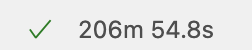